In [9]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [11]:
animal, sess_name = 'Rey', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [12]:
print(sess.eegfile)

duration: 15306.85 seconds 
duration: 4.25 hours 



# deeplabcut

In [13]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/2_training/training/Rey/gobears/2022_05_09/12_16_30/My_WebCam/Rey_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


,back_middle,crown_middle,left_ear,neck_base,nose,right_ear,tail_base,tail_end,tail_middle
0,NaN,NaN,0.515211,0.905169,1.822689,0.450430,0.351404,0.876854,66.498583
1,NaN,NaN,1.129647,2.958141,1.287209,0.747608,0.487607,132.199561,138.755819
2,NaN,NaN,3.221762,2.088302,213.974737,0.832356,1.636033,8.059578,0.898520
3,NaN,NaN,1.642432,1.012797,3.166159,0.611040,0.961728,229.099002,200.303078
4,NaN,NaN,0.246299,0.619794,206.459708,1.356669,0.252626,84.490272,6.809151
...,...,...,...,...,...,...,...,...,...
61210,NaN,NaN,2.393919,3.799567,8.393495,6.529831,1.355460,1.809792,3.341399
61211,NaN,NaN,0.657908,2.739459,8.092463,4.615843,0.534351,4.250159,3.950690
61212,NaN,NaN,2.395407,4.620333,3.000306,4.069628,1.132349,6.870084,2.367267
61213,NaN,NaN,1.238671,2.297245,3.777264,1.383719,1.506028,1.262288,1.958646


In [14]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-05-09 12:06:13.678315-04:00
start time = 2022-05-09 12:15:08.781851-04:00
start time = 2022-05-09 12:33:20.854076-04:00
start time = 2022-05-09 12:39:03.160744-04:00
start time = 2022-05-09 12:48:12.124560-04:00
start time = 2022-05-09 12:54:42.702826-04:00
start time = 2022-05-09 13:04:08.630558-04:00
start time = 2022-05-09 13:58:51.401140-04:00
start time = 2022-05-09 14:08:35.718726-04:00
start time = 2022-05-09 16:10:53.170647-04:00


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Total seconds from OE start,eeg_time
0,0,-70,0,2022-05-09 12:16:30.527000-04:00,616.848685,515.025110
1,1,28,0,2022-05-09 12:16:30.625000-04:00,616.946685,515.123110
2,2,75,0,2022-05-09 12:16:30.672000-04:00,616.993685,515.170110
3,3,106,0,2022-05-09 12:16:30.703000-04:00,617.024685,515.201110
4,4,138,0,2022-05-09 12:16:30.735000-04:00,617.056685,515.233110
...,...,...,...,...,...,...
61210,61210,2044617,0,2022-05-09 12:50:35.214000-04:00,2661.535685,2499.210641
61211,61211,2044650,0,2022-05-09 12:50:35.247000-04:00,2661.568685,2499.243641
61212,61212,2044681,0,2022-05-09 12:50:35.278000-04:00,2661.599685,2499.274641
61213,61213,2044713,0,2022-05-09 12:50:35.310000-04:00,2661.631685,2499.306641


In [15]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

58 epochs
Snippet: 
          start         stop  duration label
0  1330.062723  1331.070722  1.008000  high
1  1347.006715  1348.142714  1.135999  high
2  1366.894705  1369.774704  2.879999  high
3  1370.462704  1371.870703  1.407999  high
4  1379.198699  1380.430699  1.231999  high

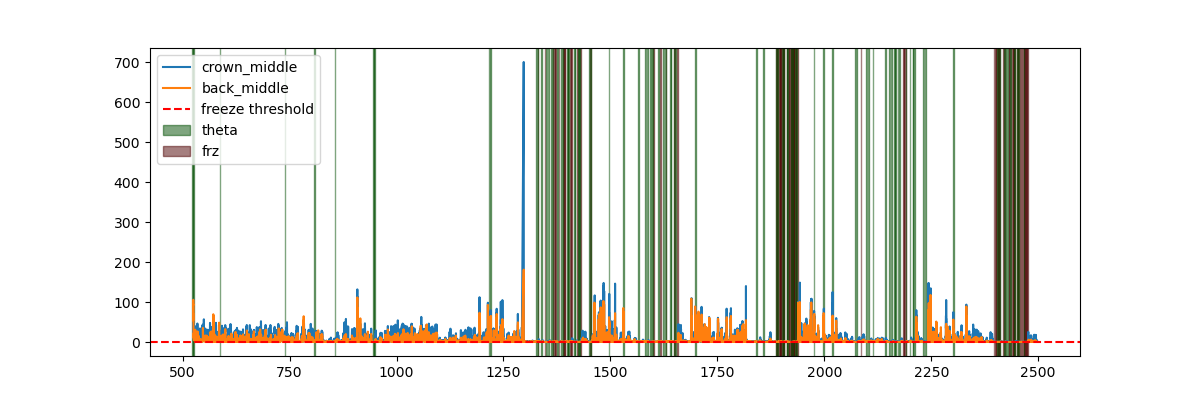

In [16]:
%matplotlib widget
# Plot to check! Looks ok, though there might be some mismatches between theta and movement.

_, ax = plt.subplots(figsize=(12, 4))
hc, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["crown_middle"])
hb, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = sess.dlc.timestamps["eeg_time"].min(), t_stop=sess.dlc.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))

,channel_states,timestamps,datetimes,event_name


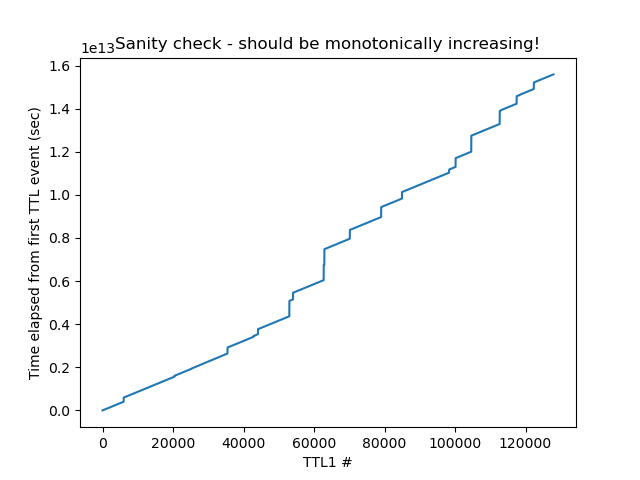

In [17]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

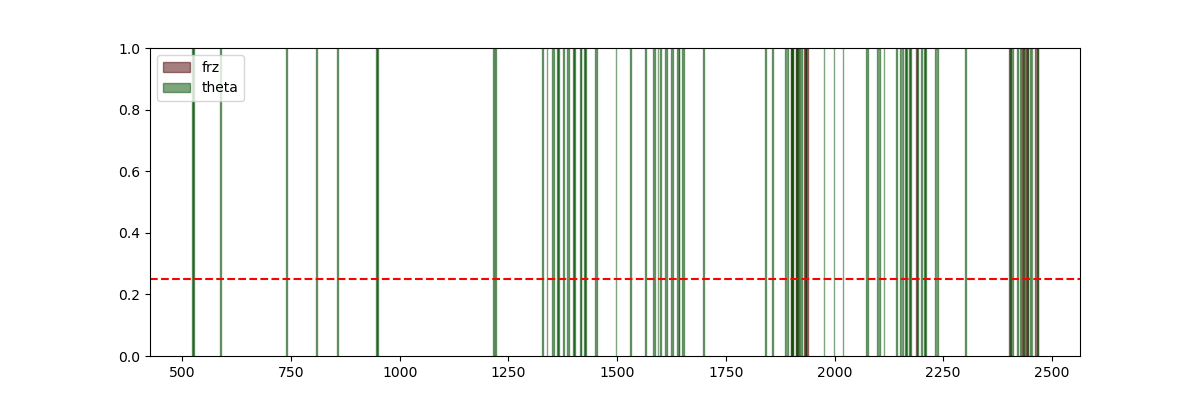

In [18]:
#Freezing and theta
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 3:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='theta')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

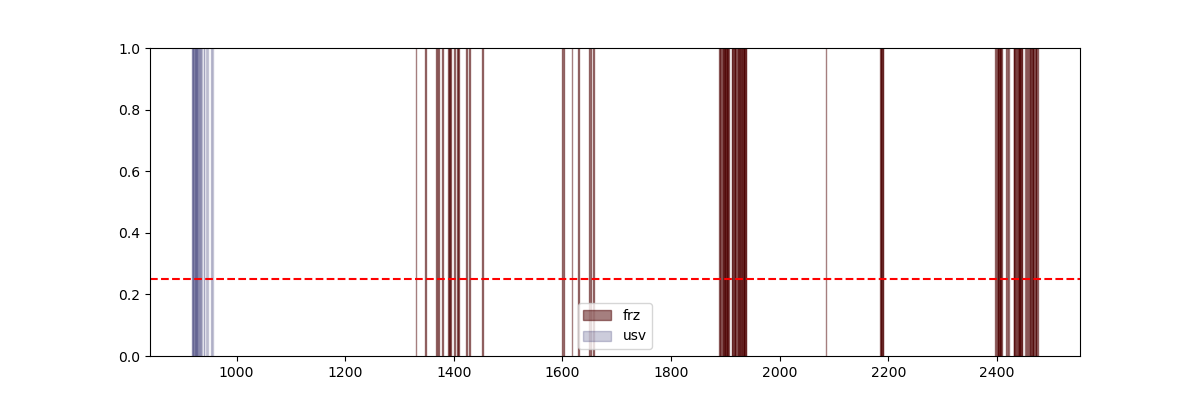

In [19]:
#Freezing and USV
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')
    if duration > 3:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


# delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
# delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
# delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(usv_epochs.starts, usv_epochs.stops):
    duration = stop-start

    husv = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.2], label='usv')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

In [20]:
usv_epochs

31 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  918.489945  918.545653  454.143559  41.270313  0.058728   12.706250    1.0   
1  918.830174  918.913128  454.502235  48.738021  0.087452    9.696875    1.0   
2  919.498451  919.591260  455.206745  39.821354  0.097841   14.378125    1.0   
3  920.429279  920.545830  456.188042  41.381771  0.122870   12.594792    1.0   
4  920.954249  921.046723  456.741475  41.716146  0.097488    6.353125    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## Save notebook to animal working directory

In [5]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Sync_USV_and_Ephys(Rey).ipynb saved to /data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_Sync_USV_and_Ephys(Rey).ipynb


### Load in disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 420.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,525.4256,526.4848,None,1.0592
1,907.5878,909.1142,None,1.5264
2,1193.1820,1195.0756,None,1.8936
3,1289.0000,1325.0000,None,36.0000
4,1461.7138,1464.6570,None,2.9432
5,1476.5684,1485.5380,None,8.9696
6,1688.1572,1691.0132,None,2.8560
7,1705.0242,1708.2290,None,3.2048
8,1750.7670,1752.6990,None,1.9320
9,1759.8918,1760.9766,None,1.0848


<Axes: >

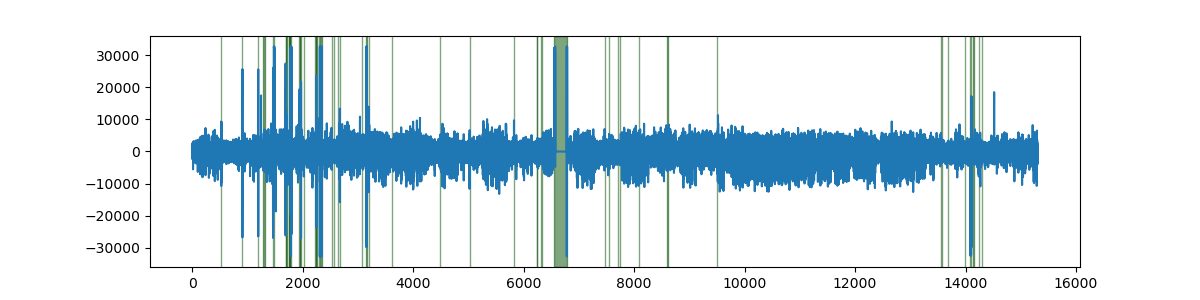

In [7]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.probegroup.npy saved


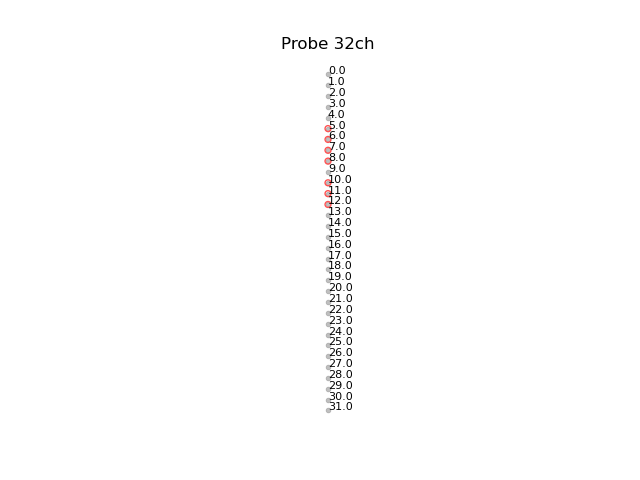

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [9]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 26

if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [26]
1144 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [10]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 26
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [26]
7908 epochs remaining with durations within (0.05,0.45)


# Detect Delta

In [11]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 26  

freq_band = (1, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal

try:
    delta_epochs = detect_hpc_delta_wave_epochs(
        signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
    )
except AssertionError as e:
    if str(e) == "Found multiple peaks within troughs":
        pass  
    else:
        raise

2539 delta waves detected


In [12]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 26
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for beta: [26]
900 epochs remaining with durations within (1,20)


In [13]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 18

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

In [14]:
sess.basepath

PosixPath('/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training')

,channel_states,timestamps,datetimes,event_name


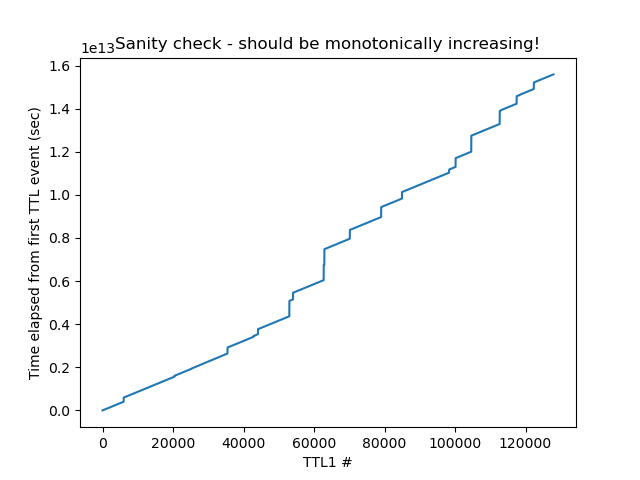

In [15]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [16]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    #csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          #event_type="CS-", return_df=True)
    #print(f'{csn_starts.shape[0]} CS- events detected')
    #print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

6 CS+ events detected
       Time (s)      Event                     Timestamp
6    362.604361  CS1_start 2022-05-09 12:22:33.195551057
16   648.187308  CS2_start 2022-05-09 12:27:18.778498311
26   916.697974  CS3_start 2022-05-09 12:31:47.289163967
36  1183.196727  CS4_start 2022-05-09 12:36:13.787917037
46  1473.800406  CS5_start 2022-05-09 12:41:04.391595741
56  1748.357338  CS6_start 2022-05-09 12:45:38.948527713


In [17]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-05-09 12:06:13.678315-04:00
start time = 2022-05-09 12:15:08.781851-04:00
start time = 2022-05-09 12:33:20.854076-04:00
start time = 2022-05-09 12:39:03.160744-04:00
start time = 2022-05-09 12:48:12.124560-04:00
start time = 2022-05-09 12:54:42.702826-04:00
start time = 2022-05-09 13:04:08.630558-04:00
start time = 2022-05-09 13:58:51.401140-04:00
start time = 2022-05-09 14:08:35.718726-04:00
start time = 2022-05-09 16:10:53.170647-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-05-09 12:06:13.678315-04:00,start,0,0.000000,0,0.0000
1,0,2022-05-09 12:13:26.958281667-04:00,stop,12998399,433.279967,541599,433.2792
2,1,2022-05-09 12:15:08.781851-04:00,start,12998400,433.280000,541600,433.2800
3,1,2022-05-09 12:32:40.796751-04:00,stop,44558847,1485.294900,1856618,1485.2944
4,2,2022-05-09 12:33:20.854076-04:00,start,44558848,1485.294933,1856619,1485.2952
5,2,2022-05-09 12:38:52.356976-04:00,stop,54503935,1816.797833,2270997,1816.7976
6,3,2022-05-09 12:39:03.160744-04:00,start,54503936,1816.797867,2270998,1816.7984
7,3,2022-05-09 12:48:02.484444-04:00,stop,70683647,2356.121567,2945151,2356.1208
8,4,2022-05-09 12:48:12.124560-04:00,start,70683648,2356.121600,2945152,2356.1216
9,4,2022-05-09 12:52:47.222126667-04:00,stop,78936575,2631.219167,3289023,2631.2184


In [18]:
ttl_df.channel_states

0      -1
1       1
2      -1
3       1
4      -1
       ..
9403   -1
9404    1
9405   -1
9406    1
9407   -1
Name: channel_states, Length: 127915, dtype: int16

In [19]:
127915/15/60

142.12777777777777

In [20]:
ttl_df[ttl_df['channel_states'].abs() == 2]

,channel_states,timestamps,datetimes,event_name


In [22]:
# Grab CS times corresponding to OE timestamps
# Note that for Rey this DOES NOT work since TTL2 was not recorded for some reason, use rough timestamps from CSV file in code block below
#ttl_lag_use = pd.Timedelta(5, unit="seconds")
#cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  #ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  #ttl_lag=ttl_lag_use)
#cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  #ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  #ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
#cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
#cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

#csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  #ttl_df[ttl_df['channel_states'].abs() == 2], 
#                                  ttl_lag=ttl_lag_use*2)
#csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  #ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  #ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
#csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
#csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)
##Problems in this step!!


In [23]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name


In [24]:
if animal == "Rey":
    cs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
    cs_epochs = Epoch(epochs=None, file=cs_file)
    cs_starts_combined, cs_stops_combined = cs_epochs.starts, cs_epochs.stops
    cs_oe_start_df["channel_states"] = 2
    
    csn_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
    csn_epochs = Epoch(epochs=None, file=csn_file)
    csn_starts_combined, csn_stops_combined = csn_epochs.starts, csn_epochs.stops

In [25]:
cs_oe_start_df.loc[:, "datetimes", ] = cs_starts["Timestamp"].values[0]
cs_oe_start_df = pd.DataFrame({"channel_states" : 2, "timestamps" : "", 
                               "datetimes" : cs_starts["Timestamp"].dt.tz_localize("America/Detroit"), 
                               "event_name" : ""})
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name
6,2,,2022-05-09 12:22:33.195551057-04:00,
16,2,,2022-05-09 12:27:18.778498311-04:00,
26,2,,2022-05-09 12:31:47.289163967-04:00,
36,2,,2022-05-09 12:36:13.787917037-04:00,
46,2,,2022-05-09 12:41:04.391595741-04:00,
56,2,,2022-05-09 12:45:38.948527713-04:00,


In [26]:
cs_oe_stop_df.loc[:, "datetimes", ] = cs_stops["Timestamp"].values[0]
cs_oe_stop_df = pd.DataFrame({"channel_states" : 2, "timestamps" : "", 
                               "datetimes" : cs_starts["Timestamp"].dt.tz_localize("America/Detroit"), 
                               "event_name" : ""})
cs_oe_stop_df

,channel_states,timestamps,datetimes,event_name
6,2,,2022-05-09 12:22:33.195551057-04:00,
16,2,,2022-05-09 12:27:18.778498311-04:00,
26,2,,2022-05-09 12:31:47.289163967-04:00,
36,2,,2022-05-09 12:36:13.787917037-04:00,
46,2,,2022-05-09 12:41:04.391595741-04:00,
56,2,,2022-05-09 12:45:38.948527713-04:00,


In [27]:
cs_starts["Timestamp"].values[0] + pd.Timedelta(10, unit="seconds")

Timestamp('2022-05-09 12:22:43.195551057')

In [28]:
cs_starts["Timestamp"].dt.tz_localize("America/Detroit")

6    2022-05-09 12:22:33.195551057-04:00
16   2022-05-09 12:27:18.778498311-04:00
26   2022-05-09 12:31:47.289163967-04:00
36   2022-05-09 12:36:13.787917037-04:00
46   2022-05-09 12:41:04.391595741-04:00
56   2022-05-09 12:45:38.948527713-04:00
Name: Timestamp, dtype: datetime64[ns, America/Detroit]

In [29]:
cs_durations = cs_stops_combined - cs_starts_combined
cs_durations

array([9.919571, 9.936539, 9.936541, 9.917577, 9.934044, 9.93754 ])

### How to write CS+ to neuroscope event file

In [30]:
cs_epochs

6 epochs
Snippet: 
          start         stop label
0   877.693700   887.613271      
1  1163.276647  1173.213186      
2  1431.787312  1441.723853      
3  1658.229041  1668.146618      
4  1938.029251  1947.963295      

In [31]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [32]:
cs_tone_recall_epochs

6 epochs
Snippet: 
          start         stop label
0   877.693700   887.613271   CS+
1  1163.276647  1173.213186   CS+
2  1431.787312  1441.723853   CS+
3  1658.229041  1668.146618   CS+
4  1938.029251  1947.963295   CS+

/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/2_training/shockbox/T0000001.WAV
Mean start lag time of 437.427 sec with std = 22.579 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 437.017 sec with std = 22.602 sec.


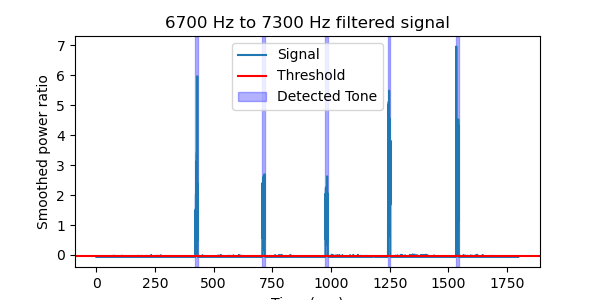

In [33]:
# Detect CS+ in audio recording.
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs, cs_wav_stop = detect_tone(csp_wav, freq_lims=(6700, 7300), thresh=-0.035, tone_length=5, tone_label="CS+", 
                                         plot_check=True, return_stop=True)
# Check that lags are consistent
try:
    cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
except ValueError:  
    if animal == "Rey":  # WAV file is split into two, so we lose the last tone.
        cs_start_lags = cs_starts_combined[:5] - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
try:
    cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
except ValueError:
    if animal == "Rey":
        cs_stop_lags = cs_stops_combined[:5] - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/1_tone_habituation/sleepbox/T0000001.WAV


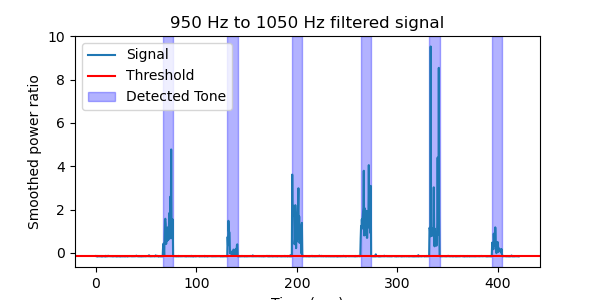

In [34]:
# Detect CS- in audio recording.
#if "shockbox" in str(sess.basepath):
    # csn_wav = sorted((sess.basepath / "1_tone_habituation").glob("**/*.wav"))[0]
csn_wav = grab_usv_folder(sess.basepath, 'csn')
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(csn_wav, freq_lims=(950, 1050), thresh=-0.15, tone_length=5.5, tone_label="CS-", plot_check=True)

# Check that lags are consistent
#csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
#print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
#csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
#print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/3_post/sleepbox/T0000002.WAV


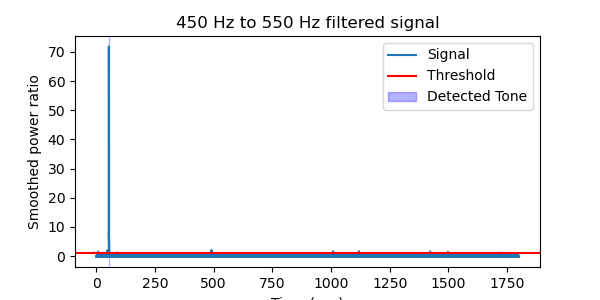

In [35]:
no_tone_wav = grab_usv_folder(sess.basepath, "sync")
print(no_tone_wav)

#Get CS+ times and plot to check
start_wav_epochs, start_wav_stop = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=1, tone_length=0.5, tone_label="start_tone", 
                               plot_check=True, return_stop=True)

Now try to sync to start tone 

## Sync recorded USV times to ephys file

In [36]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(Path(csp_wav).parent.glob(f"**/{Path(csp_wav).name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df.sample(5)

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
9,461.007357,43.388021,0.054691,9.473958,1.000000,1
22,470.485862,53.500000,0.026765,9.777778,1.000000,1
0,454.143559,41.270313,0.058728,12.706250,1.000000,1
3,456.188042,41.381771,0.122870,12.594792,1.000000,1
5,456.981976,25.000000,0.885293,11.625000,0.542208,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

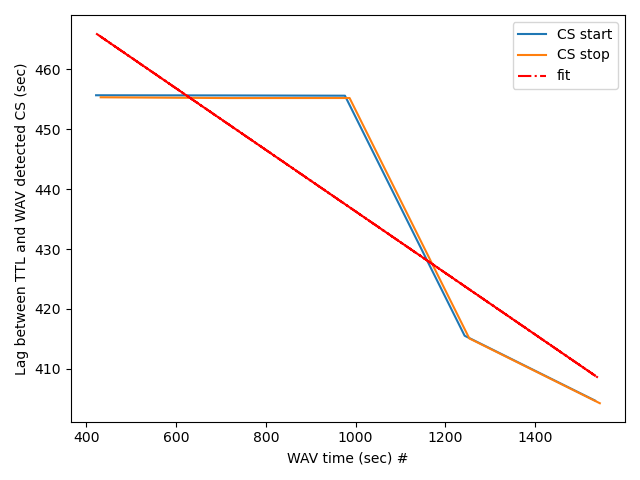

In [37]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [38]:
def get_wav_to_dat_equation(cs_wav_epochs, cs_start_lags, cs_stop_lags, sync_df):
    """Get equation to convert cs times to dat file times"""
    pass
    # 1) Get rough alignment by identifying FIRST tone and getting datetime for each tone

    # 2) Identify any disconnect times and split into epochs of continuous recording

    # 3) Call function recursively for each epoch

    # 4) Fit a line to the lag data - in the case that there is only one point, return a Nan

    # 5) Go back and re-fit any NaN epochs using the mean slope from another epoch

    # 6) Return a dataframe with epoch start stop (from sync file) + appropriate slope and intercept to use!
    

In [39]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name
6,2,,2022-05-09 12:22:33.195551057-04:00,
16,2,,2022-05-09 12:27:18.778498311-04:00,
26,2,,2022-05-09 12:31:47.289163967-04:00,
36,2,,2022-05-09 12:36:13.787917037-04:00,
46,2,,2022-05-09 12:41:04.391595741-04:00,
56,2,,2022-05-09 12:45:38.948527713-04:00,


In [40]:
wav_rough_start = cs_oe_start_df.iloc[0].datetimes - pd.Timedelta(cs_times_wav[0][0], 'seconds')
print(wav_rough_start)
wav_rough_stop = wav_rough_start + pd.Timedelta(cs_wav_stop, 'seconds')
print(wav_rough_stop)

2022-05-09 12:15:31.184342266-04:00
2022-05-09 12:45:31.196155453-04:00


In [41]:
def sync_rec_to_eeg(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp):
    """Get start and stop times of outside recording in eeg time"""
    # ID which eeg recordings the external recording spanned.
    start_stop_long = np.array([rec_start.to_datetime64().astype("long"), 
                                rec_stop.to_datetime64().astype("long")])
    sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
    indx_bool, t, _, bin_loc = sync_dt_epochs.contains(start_stop_long, return_closest=True)
    rec_span = (bin_loc/2).astype(int)

    # Identify overall start and stop time of external recording
    eeg_start_stop = []
    for t_interp, nrec in zip(start_stop_long, rec_span):
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
        eeg_time_interp = np.interp(t_interp, 
                                   [start_df.Datetime.values[0].astype("long"), stop_df.Datetime.values[0].astype("long")],
                                   [start_df.eeg_time.values[0], stop_df.eeg_time.values[0]])
        eeg_start_stop.append(eeg_time_interp)

    eeg_start_stop = np.array(eeg_start_stop)

    return eeg_start_stop, rec_span
        

    
sync_rec_to_eeg(sync_df, wav_rough_start, wav_rough_stop)  

(array([ 455.68248074, 2204.83287615]), array([1, 3]))

In [42]:
def external_rec_sync_df(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp, rec_dur: float, rec_str="rec"):
    """Create dataframe identifying the start and stop times in the external file corresponding to eeg recording times."""

    # Get recording start and stop times in long format
    rec_start_stop_long = [rec_start.to_datetime64().astype("long"), rec_stop.to_datetime64().astype("long")]

    # Figure out start and stop times in eeg file time
    eeg_start_stop, rec_span = sync_rec_to_eeg(sync_df, rec_start, rec_stop)

    # Loop through and find start/stop of external recording that corresponds to eeg file times.
    rec_start_stops_all, eeg_start_stops_all = [], []
    eeg_recs = np.arange(rec_span[0], rec_span[1] + 1)
    for nrec in eeg_recs:
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
        # rec_dur = stop_df['eeg_time'].values[0] - start_df['eeg_time'].values[0]
        # print(rec_dur)
    
        # Get legit external recording times corresponding to eeg times in long datetime format
        nrec_epoch_start = np.max((rec_start, pd.Timestamp(start_df.Datetime.iloc[0])))
        nrec_epoch_stop = np.min((rec_stop, pd.Timestamp(stop_df.Datetime.iloc[0])))
        nrec_start_stop_long = [nrec_epoch_start.to_datetime64().astype("long"),
                               nrec_epoch_stop.to_datetime64().astype("long")]
    
        # Get corresdonding eeg file times
        nrec_eeg_start = start_df.eeg_time.values[0]
        nrec_eeg_stop = stop_df.eeg_time.values[0]
        nrec_eeg_start_stop = [nrec_eeg_start, nrec_eeg_stop]
        eeg_start_stops_all.append(nrec_eeg_start_stop)
    
        # Grab wav file start and stops
        rec_start_stops = np.interp(nrec_start_stop_long, rec_start_stop_long, [0, rec_dur])
        rec_start_stops_all.append(rec_start_stops)
        
    eeg_start_stops_all = np.array(eeg_start_stops_all)
    rec_start_stops_all = np.array(rec_start_stops_all)
    
    return pd.DataFrame({"nrec": eeg_recs, "eeg_start": eeg_start_stops_all[:, 0], "eeg_stop": eeg_start_stops_all[:, 1],
                        f"{rec_str}_start": rec_start_stops_all[:, 0], f"{rec_str}_stop": rec_start_stops_all[:, 1]})
    
rec_start, rec_stop = wav_rough_start, wav_rough_stop
external_rec_sync_df(sync_df, rec_start, rec_stop, cs_wav_stop, "wav")

,nrec,eeg_start,eeg_stop,wav_start,wav_stop
0,1,433.2800,1485.2944,0.000000,1029.612409
1,2,1485.2952,1816.7976,1069.669734,1401.172634
2,3,1816.7984,2356.1208,1411.976402,1800.011813


In [43]:
cs_times_wav

array([[ 422.01120879,  432.27203297],
       [ 707.62296703,  718.00148352],
       [ 976.17846154,  986.50318681],
       [1242.71450549, 1253.07692308],
       [1533.355     , 1543.72263736]])

In [44]:
# Reshape inputs
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)

def fit_line_to_lags(times_wav, oe_lags_comb, use_slope=-0.0001687172):

    if times_wav.shape[0] > 1:
        # Fit function to approximate drift
        y = oe_lags_comb.T.reshape(-1)
        M = np.stack((np.ones_like(oe_lags_comb.reshape(-1)), times_wav.T.reshape(-1)), axis=1)
        p, res, rnk, s = lstsq(M, y)

    else:
        if use_slope is None:
            p = np.nan
        else:
            p1 = use_slope
            p0 = oe_lags_comb.mean() - p1 * times_wav.mean()
            p = (p0, p1)

    return p

# 2) Identify roughly where each tone occurred
sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
indx_bool, _, _ = sync_dt_epochs.contains(cs_oe_start_df.datetimes.values.astype("long"))
rec_number = (np.digitize(cs_oe_start_df.datetimes.values.astype("long")[indx_bool], sync_dt_epochs.flatten()) - 1) /2
rec_number = rec_number[indx_bool].astype(int)
rec_numbers = np.unique(rec_number)
nepochs = len(rec_numbers)

# Bugfix for having last CS cutoff during training in Rey session
if "Rey" in animal:
    rec_number = rec_number[:-1]  # Cut off last theoretical CS call

# 3-4) Call each session and fit a line
p_list = []
for nrec in np.unique(rec_number):
    use_slope = -0.0001687172 if (nrec == 1) else p_list[0][1]  # use slope from first recording to estimate slope
    p_list.append(fit_line_to_lags(cs_times_wav[rec_number == nrec], cs_lags_comb[rec_number == nrec],
                                   use_slope=use_slope))
p_bool = np.array([~np.all(np.isnan(p)) for p in p_list])
pid_good = np.where(p_bool)[0]
pid_bad = np.where(~p_bool)[0]
slope_use = np.nanmean([p if np.all(np.isnan(p)) else p[1] for p in p_list])

# 5) Go back and refit
p_list_refit = []
wav_starts, wav_stops = [], []
for pid in np.unique(rec_number):

    # Get fits for each ephys recordings number
    if (pid + 1) in pid_good:  # use existing line values if good fit to begin with and > 2 points
        p_list_refit.append(p_list[pid])
    else:
        p_list_refit.append(fit_line_to_lags(cs_times_wav[rec_number == pid], 
                                             cs_lags_comb[rec_number == pid], use_slope=slope_use))
    if (animal != "Rey") and ("training" in str(sess.basepath)):
        p_refit = np.array(p_list_refit)
    else:
        p_refit = np.array(p_list)


# 6) Get df of wav starts and stops
rec_rough_start = cs_oe_start_df.iloc[0].datetimes - pd.Timedelta(cs_times_wav[0][0], 'seconds')
rec_rough_stop = wav_rough_start + pd.Timedelta(cs_wav_stop, 'seconds')
wav_sync_df = external_rec_sync_df(sync_df, rec_rough_start, rec_rough_stop, cs_wav_stop, "wav") # Bowen copy this line

# 7) Add in slopes
wav_sync_df = wav_sync_df.merge(pd.DataFrame({"nrec": np.unique(rec_number), "p0": p_refit[:, 0], "p1": p_refit[:, 1]}))

wav_sync_df

,nrec,eeg_start,eeg_stop,wav_start,wav_stop,p0,p1
0,1,433.2800,1485.2944,0.000000,1029.612409,455.591616,-0.000196
1,2,1485.2952,1816.7976,1069.669734,1401.172634,415.536561,-0.000196
2,3,1816.7984,2356.1208,1411.976402,1800.011813,404.758833,-0.000196


In [45]:
rec_number

array([1, 1, 1, 2, 3])

In [46]:
p_list_refit

[(415.5365610548741, -0.00019588643328927074),
 (415.5365610548741, -0.00019588643328927074),
 (404.75883320034984, -0.00019588643328927074)]

In [47]:
slope_use

-0.00019588643328927074

In [48]:
p_list

[array([ 4.55591616e+02, -1.95886433e-04]),
 (415.5365610548741, -0.00019588643328927074),
 (404.75883320034984, -0.00019588643328927074)]

In [49]:
fit_line_to_lags(cs_times_wav[rec_number == 1], cs_lags_comb[rec_number == 1])

array([ 4.55591616e+02, -1.95886433e-04])

In [50]:
cs_times_wav[rec_number == 1]

array([[422.01120879, 432.27203297],
       [707.62296703, 718.00148352],
       [976.17846154, 986.50318681]])

In [51]:
cs_lags_comb[rec_number == 1]

array([[455.68249121, 455.34123803],
       [455.65367997, 455.21170248],
       [455.60885046, 455.22066619]])

In [52]:
cs_lags_comb

array([[455.68249121, 455.34123803],
       [455.65367997, 455.21170248],
       [455.60885046, 455.22066619],
       [415.51453551, 415.06969492],
       [404.674251  , 404.24065764]])

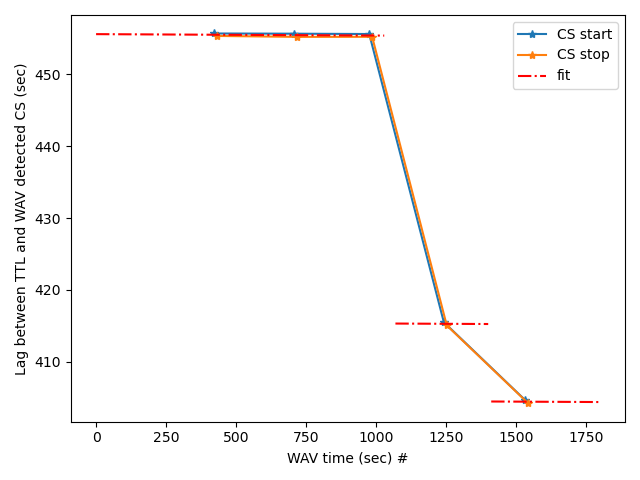

In [53]:
_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb, '-*')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
for nrec in np.unique(rec_number):
    
    wav_times = wav_sync_df.loc[wav_sync_df.nrec == nrec, ["wav_start", "wav_stop"]].values.squeeze()
    hfit = ax.plot(wav_times, wav_sync_df[wav_sync_df.nrec == nrec].p0.values + 
                   wav_sync_df[wav_sync_df.nrec == nrec].p1.values*wav_times, 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [54]:
def get_rec_num(rec_sync_df, times):
    """Identify in which recording each time in times occurs"""
    bin_loc = np.digitize(times, rec_sync_df.loc[:, ["wav_start", "wav_stop"]].values.flatten("C"))
    indx_bool = bin_loc % 2 == 1
    
    indx_bool = bin_loc % 2 == 1
    indx_good = np.where(indx_bool)
    indx_bad = np.where(~indx_bool)
    
    nrec_ids = np.ones_like(indx_bool, dtype='int')
    bin_ind = (bin_loc / 2).astype(int)
    if np.any(indx_good):
        nrec_ids[indx_good] = rec_sync_df.loc[bin_ind[indx_good], "nrec"].values
    
    if np.any(indx_bad):
        nrec_ids[indx_bad] = -1

    
    return nrec_ids

get_rec_num(wav_sync_df , cs_wav_epochs.starts)

array([1, 1, 1, 2, 3])

In [55]:
from copy import deepcopy

def wav_epochs_to_eeg(wav_epochs_df, wav_sync_df):
    """wav_epochs_df must have start and stop field for each index"""
    wav_epochs_df2 = deepcopy(wav_epochs_df)
    nrec_start = get_rec_num(wav_sync_df, wav_epochs_df2.start)
    nrec_stop = get_rec_num(wav_sync_df, wav_epochs_df2.stop)
    nrec_bool = nrec_start == nrec_stop
    nrec_good = np.ones_like(nrec_start) * -1
    nrec_good[nrec_bool] = nrec_start
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], column="nrec", value=nrec_good)

    # Initialize default values for t_starts and t_stops
    t_starts = [None] * len(wav_epochs_df2)
    t_stops = [None] * len(wav_epochs_df2)
    
    for idx, it in enumerate(wav_epochs_df2.itertuples()):
        p_use = wav_sync_df.loc[wav_sync_df.nrec == it.nrec, ["p0", "p1"]].values.squeeze()
        if p_use.size > 0:
            t_start = it.start + p_use[0] + p_use[1] * it.start
            t_stop = it.stop + p_use[0] + p_use[1] * it.stop
            t_starts[idx] = t_start
            t_stops[idx] = t_stop
    
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_start_eeg", t_starts)
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_stop_eeg", t_stops)
    
    return wav_epochs_df2


In [56]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.cs_wav_epochs.npy saved


In [57]:
cs_wav_epochs_aligned

5 epochs
Snippet: 
          start         stop              label
0   888.010181   897.743285  CS+ from WAV file
1  1158.932758  1168.777502  CS+ from WAV file
2  1413.676286  1423.470004  CS+ from WAV file
3  1666.504224  1676.333697  CS+ from WAV file
4  1942.196907  1952.031331  CS+ from WAV file

Now correct that drift and find corrected lags!

In [58]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.usv_epochs.npy saved


In [59]:
good_calls

31 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  918.489945  918.545653  454.143559  41.270313  0.058728   12.706250    1.0   
1  918.830174  918.913128  454.502235  48.738021  0.087452    9.696875    1.0   
2  919.498451  919.591260  455.206745  39.821354  0.097841   14.378125    1.0   
3  920.429279  920.545830  456.188042  41.381771  0.122870   12.594792    1.0   
4  920.954249  921.046723  456.741475  41.716146  0.097488    6.353125    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## Save notebook to working directory

In [60]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [61]:
pip install jupyter-save-load-vars

Note: you may need to restart the kernel to use updated packages.
